In [25]:
!pip install -U tf_keras

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [27]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [28]:
NUM_CLASSES = 26

# Dataset reading

In [29]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [30]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [33]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,866 (65.88 KB)

 Trainable params: 16,782 (65.55 KB)

 Non-trainable params: 84 (336.00 B)

In [34]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [35]:
# Model compilation
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [36]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
208/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1270 - loss: 4.4709
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1289 - loss: 4.4518 - val_accuracy: 0.2803 - val_loss: 3.1022
Epoch 2/1000
201/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2719 - loss: 2.9387
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2728 - loss: 2.9304 - val_accuracy: 0.3735 - val_loss: 2.4366
Epoch 3/1000
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3275 - loss: 2.5345
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3276 - loss: 2.5341 - val_accuracy: 0.4525 - val_loss: 2.1977
Epoch 4/1000
208/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3760 - loss: 2.3741
Epoch 4: saving model to model/keypoint_classifier/keypoint_classi

In [37]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.8628 - loss: 0.7293


In [38]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [39]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[3.8220454e-04 2.4751741e-09 3.2071366e-08 1.3950454e-06 9.7733187e-07
 9.7853735e-06 1.4810395e-06 1.2820120e-11 8.5826701e-04 2.4623555e-04
 1.2664295e-06 5.8222064e-05 2.1819480e-06 9.4522399e-09 2.1371472e-06
 2.0805953e-09 2.3238540e-09 1.0883663e-10 4.0878322e-07 2.3932624e-05
 4.6047446e-10 1.0890381e-08 1.9023062e-07 4.0474461e-07 9.9841082e-01
 3.0323932e-08]
24


# Confusion matrix

285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step


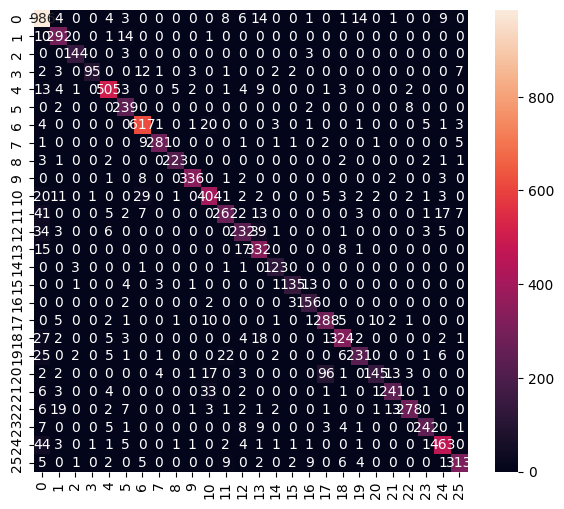

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1051
           1       0.82      0.92      0.87       318
           2       0.95      0.96      0.95       150
           3       0.98      0.74      0.84       128
           4       0.92      0.91      0.92       553
           5       0.83      0.95      0.89       251
           6       0.90      0.94      0.92       657
           7       0.97      0.93      0.95       302
           8       0.97      0.95      0.96       235
           9       0.97      0.95      0.96       353
          10       0.82      0.83      0.83       489
          11       0.85      0.73      0.78       360
          12       0.80      0.72      0.76       324
          13       0.75      0.89      0.82       373
          14       0.90      0.95      0.92       129
          15       0.94      0.85      0.89       158
          16       0.83      0.96      0.89       163
     

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [41]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [42]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

In [43]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()


open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpt4d6zmoz/assets


INFO:tensorflow:Assets written to: /tmp/tmpt4d6zmoz/assets


Saved artifact at '/tmp/tmpt4d6zmoz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  140617839034000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617839027472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617839033616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617839031120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617839031696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617839034192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617837249168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617837263760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617837261648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617837263568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140617837261840: Tens

W0000 00:00:1740052977.585943   10571 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740052977.585959   10571 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-20 20:02:57.586084: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt4d6zmoz
2025-02-20 20:02:57.586477: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-20 20:02:57.586486: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpt4d6zmoz
2025-02-20 20:02:57.590020: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-20 20:02:57.614235: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpt4d6zmoz
2025-02-20 20:02:57.622504: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 36424 microseconds.


27792

# Inference test

In [44]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [45]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [46]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [47]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 87 μs, sys: 9 μs, total: 96 μs
Wall time: 88.2 μs


In [48]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.04363585e-04 2.79794654e-09 3.41851880e-08 1.46094726e-06
 1.10274391e-06 1.02027288e-05 1.46497666e-06 1.31619845e-11
 9.32555995e-04 2.58338841e-04 1.28490080e-06 6.01476386e-05
 2.39760925e-06 1.04417142e-08 2.34397021e-06 2.23646013e-09
 2.44896414e-09 1.20729635e-10 4.38552576e-07 2.52863829e-05
 4.98260821e-10 1.13941780e-08 2.05650153e-07 4.45344114e-07
 9.98297870e-01 3.12861381e-08]
24
